In [162]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

In [139]:
labelled_pv_pos_df = pd.read_csv('Data/All_Pos_PV_DS.csv')
labelled_pv_neg_df = pd.read_csv('Data/All_Neg_PV_DS.csv')
Unlabelled_turkish_tweets_df = pd.read_csv('Data/turkish_protests_unduplicated_100000.csv')
labelled_violence_tweetts_GT_df = pd.read_csv('Data/GT_Data_extra_aggregated.csv')

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [140]:
len(labelled_pv_pos_df)

50000

In [141]:
len(labelled_pv_neg_df)

477806

In [142]:
len(Unlabelled_turkish_tweets_df)

100000

In [143]:
len(labelled_violence_tweetts_GT_df)

1000

In [144]:
labelled_pv_neg_df = labelled_pv_neg_df[:4]

In [145]:
labelled_pv_pos_df = labelled_pv_pos_df[:4]

In [146]:
len(labelled_pv_neg_df)

4

In [147]:
labelled_pv_neg_df['violence'] = 0

In [148]:
labelled_pv_pos_df['violence'] = 1

In [149]:
labelled_pv_training_ds = labelled_pv_neg_df.append(labelled_pv_pos_df)

In [150]:
labelled_violence_tweetts_GT_df = labelled_violence_tweetts_GT_df[['text','violence']]

In [151]:
def k_fold_cross_validation(pipeline, df,label, n_folds):
    k_fold = KFold(n=len(df), n_folds=n_folds)
    F1_scores = []
    P_scores = []
    R_scores = []
    confusion = np.array([[0, 0], [0, 0]])
    for train_indices, test_indices in k_fold:
        train_text = df.iloc[train_indices]['text'].values
        train_y = df.iloc[train_indices][label].values

        test_text = df.iloc[test_indices]['text'].values
        test_y = df.iloc[test_indices][label].values

        pipeline.fit(train_text, train_y)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        F1_score = f1_score(test_y, predictions, pos_label=1)
        P_score = precision_score(test_y, predictions, pos_label=1)
        R_score = recall_score(test_y, predictions, pos_label=1)
        F1_scores.append(F1_score)
        P_scores.append(P_score)
        R_scores.append(R_score)

    print('Total emails classified:', len(df))
    print('F1 Score:', sum(F1_scores)/len(F1_scores))
    print('P Score:', sum(P_scores)/len(P_scores))
    print('R Score:', sum(R_scores)/len(R_scores))
    print('Confusion matrix:')
    print(confusion)

In [152]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [153]:
pipeline_violence_SGD = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english')),
    ('tfidf_transformer',  TfidfTransformer()),
    ('classifier',  SGDClassifier(random_state=42)) ])

k_fold_cross_validation(pipeline_violence_SGD, labelled_pv_training_ds, 'violence',8)

/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total emails classified: 8
F1 Score: 0.0
P Score: 0.0
R Score: 0.0
Confusion matrix:
[[3 4]
 [7 3]]


/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', aver

In [155]:
pipeline_violence_Svc = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english')),
    ('tfidf_transformer',  TfidfTransformer()),
    ('classifier',  SVC(kernel='linear', gamma=2)) ])

k_fold_cross_validation(pipeline_violence_Svc, labelled_pv_training_ds, 'violence',8)

Total emails classified: 8
F1 Score: 0.0
P Score: 0.0
R Score: 0.0
Confusion matrix:
[[2 4]
 [6 2]]


/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fatma/Do

In [164]:
y_pred = pipeline_violence_Svc.predict(labelled_violence_tweetts_GT_df.text)
print(roc_auc_score(labelled_violence_tweetts_GT_df.violence, y_pred))
print(accuracy_score(labelled_violence_tweetts_GT_df.violence, y_pred))

0.5
0.126


In [33]:
confusion = np.array([[0, 0], [0, 0]])
confusion += confusion_matrix(labelled_violence_tweetts_GT_df.violence, y_pred)
print (confusion)

[[ 72 802]
 [  1 125]]


In [157]:
#divide dataset to train test dataset
X_train, X_test, y_train, y_test = train_test_split(labelled_pv_training_ds['text'], 
                                                    labelled_pv_training_ds['violence'], 
                                                    test_size=0.33, 
                                                    random_state=42)

In [158]:
y_scores = pipeline_violence_Svc.fit(X_train, y_train).decision_function(X_test)

In [159]:
len(y_scores)

3

In [160]:
len(y_test)

3

In [161]:
roc_auc = roc_auc_score(y_test, y_scores)
print(roc_auc)

1.0


/home/fatma/Downloads/week_5_lab_solution/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


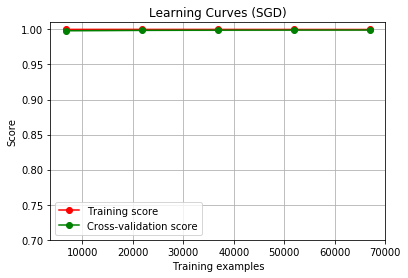

In [47]:
title = "Learning Curves (SGD)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(labelled_pv_training_ds['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator =  SGDClassifier(random_state=42)
plt = plot_learning_curve(estimator, title, X_train_counts, labelled_pv_training_ds['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=100)
plt.show()

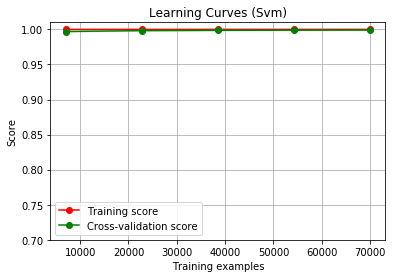

In [49]:
title = "Learning Curves (Svm)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 30% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.30, random_state=50)
count_vect = CountVectorizer(ngram_range=(1, 2),stop_words='english', min_df=10, lowercase=True, binary=True)
X_train_counts = count_vect.fit_transform(labelled_pv_training_ds['text'].values)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
estimator = SVC(kernel='linear', gamma=2)
plt = plot_learning_curve(estimator, title, X_train_counts, labelled_pv_training_ds['violence'].values, ylim=(0.7, 1.01), cv=cv, n_jobs=30)
plt.show()